In [1]:
import glob
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
WIN = 'D:/'
MAC = '/Volumes/Transcend2/'

osp = MAC

### GP sampling 

Define several kernels from GPy.

In [13]:
import GPy
k_lin = GPy.kern.Linear(1)
k_exp = GPy.kern.Exponential(1)

k_rbf = GPy.kern.RBF(input_dim=1, variance=2.25, lengthscale=1.5)
k_mat32 = GPy.kern.Matern32(input_dim=1, variance=2., lengthscale=0.2)
k_mat52 = GPy.kern.Matern52(1)

k_per = GPy.kern.StdPeriodic(1, period=3.)
k_cos = GPy.kern.Cosine(1)
k_brwn = GPy.kern.Brownian(1)
k_nn = GPy.kern.MLP(1)

Make a vector with various kernels and calculate composite kernel.

In [10]:
ks = [k_nn, k_lin, k_exp, k_rbf, k_mat32, k_mat52, k_per, k_cos, k_brwn, k_rbf+k_per,
      (k_cos+k_lin)*(k_rbf), (k_cos+k_lin)*(k_per), (k_cos+k_lin)*(k_mat52), (k_cos+k_lin)+(k_brwn) ]
ks_names = ['MLP', 'Linear', 'Exponential', 'RBF', 'Mat32', 'Mat52', 'Periodic', 'Cosine', 'Browninan', 'RBF+Browninan', 
           '(Cos+Linear)*RBF', '(Cos+Linear)*Periodic', '(Cos+Linear)*Matern52', '(Cos+Linear)+Browninan']

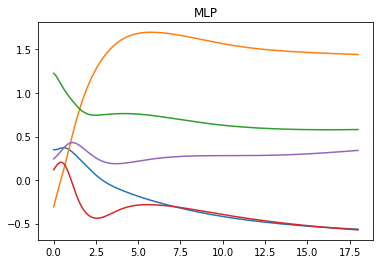

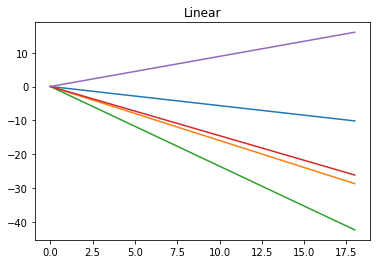

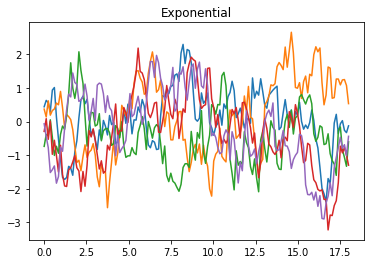

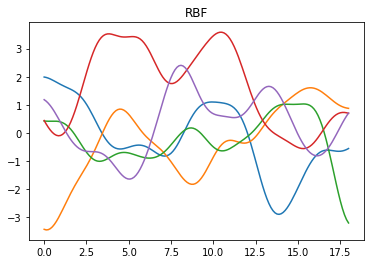

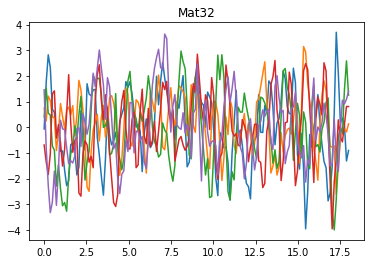

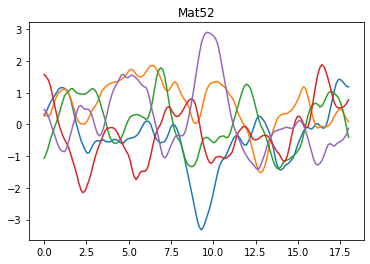

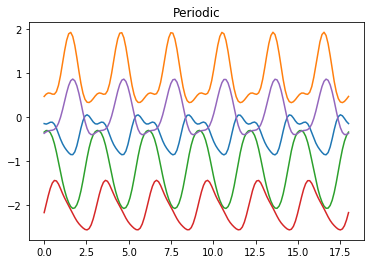

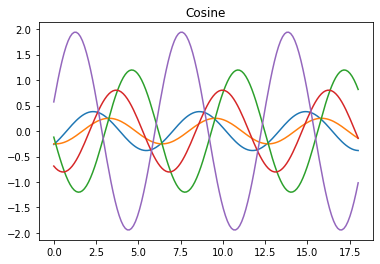

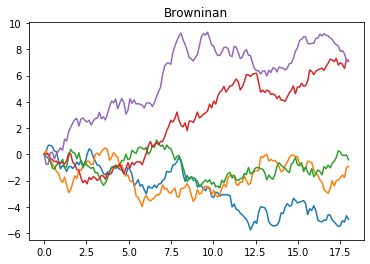

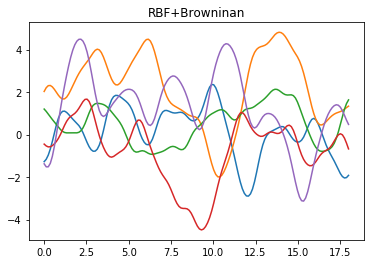

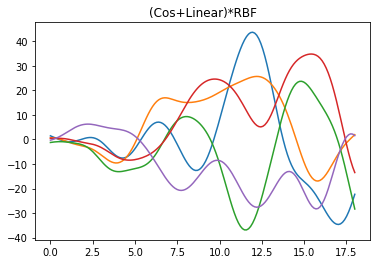

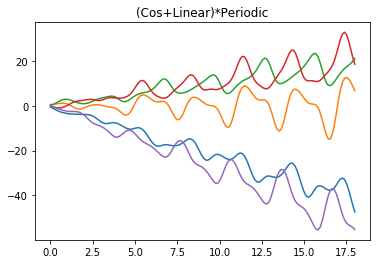

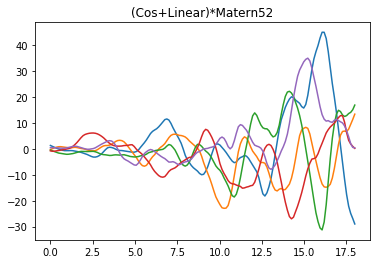

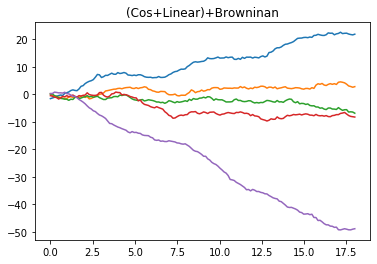

In [11]:
for k, name in zip(ks,ks_names):
    #sample from the kernel
    sample_space = np.linspace(0,18,150)[:,None]
    mu = np.zeros((150))
    C = k.K(sample_space)
        
    # Sample 5 times from a multivariate Gaussian distribution with mean 0 and covariance k(X,X)
    Z  = np.random.multivariate_normal(mu, C, 5)
    for i in range(5):
        plt.plot(sample_space, Z[i])
    plt.title(name)
    plt.show()

### GP regression for the RTs

Load the dictionary of matching standards.

In [4]:
with open(osp+'pymz/mzmine/std_matches.txt', 'rb') as file:
    matches = pickle.load(file)

#### Zika RT vs Malaria RT

In [34]:
from metab_utils import get_rts_between_datasets
mal_1_rt, zik_1_rt, mal1_zik1_diff = get_rts_between_datasets('mal', 'zik', matches)

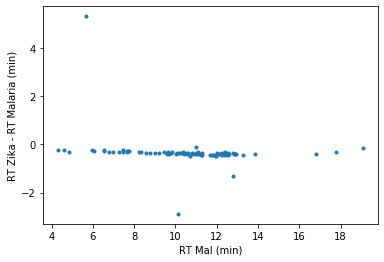

(-1, 1)

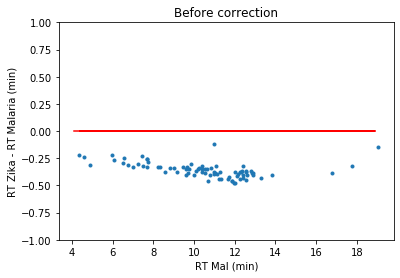

In [35]:
from metab_utils import return_data_with_no_outliers

plt.plot(np.array(mal_1_rt), np.array(zik_1_rt)-np.array(mal_1_rt), '.')
plt.xlabel('RT Mal (min)')
plt.ylabel('RT Zika - RT Malaria (min)')
#plt.ylim(-200,200)
plt.show()

mal_1_rt_mod, zik_1_rt_mod = return_data_with_no_outliers(mal_1_rt, zik_1_rt, mal1_zik1_diff, 1.4)

plt.plot(mal_1_rt_mod,zik_1_rt_mod-mal_1_rt_mod , '.')
plt.plot(zik_1_rt_mod[:,None], zik_1_rt_mod[:,None] - zik_1_rt_mod[:,None], 'r')
plt.xlabel('RT Mal (min)')
plt.ylabel('RT Zika - RT Malaria (min)')
plt.title('Before correction')
plt.ylim(-1,1)


Trying different type of kernels for the GP regression. At the end, the one with the highest cross-predicted accuracy is displayed.

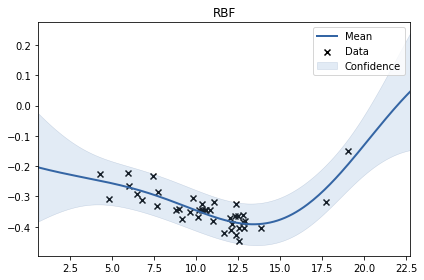

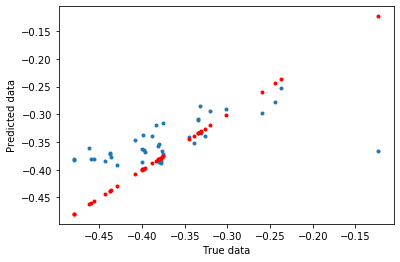

Cross-Predicted Accuracy for RBF : 0.25830305049507196
Mean absolute error for RBF : 0.044545258279286494
Mean squared error for RBF : 0.0038112195938871853


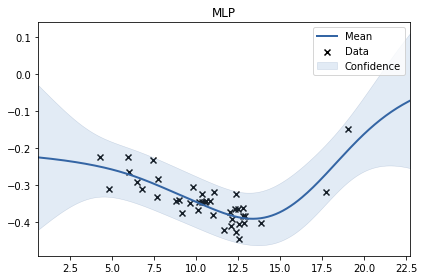

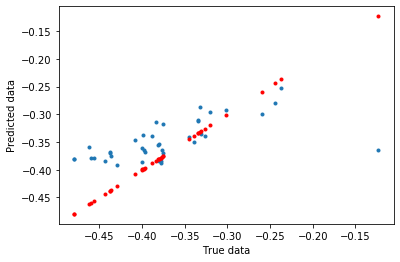

Cross-Predicted Accuracy for MLP : 0.2485080317993711
Mean absolute error for MLP : 0.04500288415301221
Mean squared error for MLP : 0.0038615514271250926


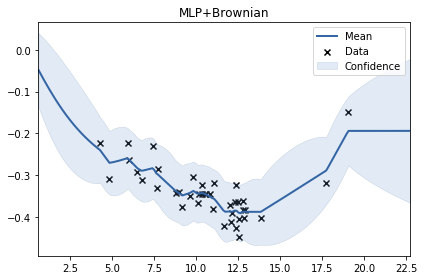

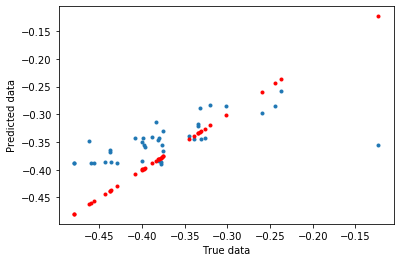

Cross-Predicted Accuracy for MLP+Brownian : 0.2671833937731054
Mean absolute error for MLP+Brownian : 0.04599371027098647
Mean squared error for MLP+Brownian : 0.0037655878323917713


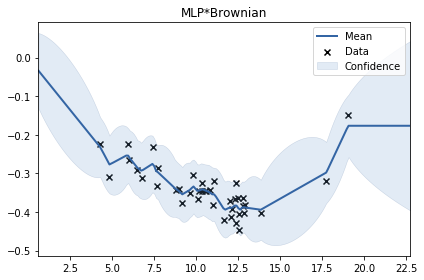

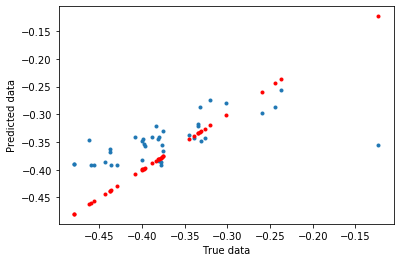

Cross-Predicted Accuracy for MLP*Brownian : 0.27647708891812084
Mean absolute error for MLP*Brownian : 0.04600827972249219
Mean squared error for MLP*Brownian : 0.0037178320568557657


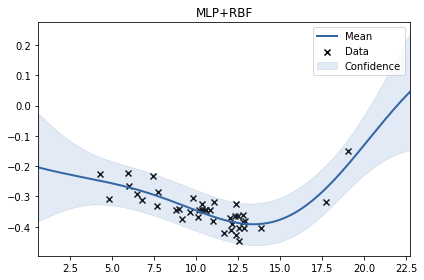

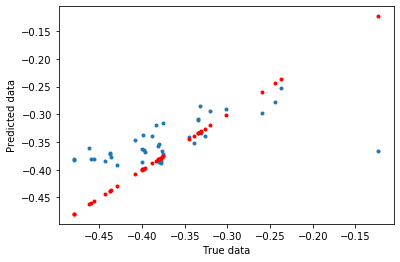

Cross-Predicted Accuracy for MLP+RBF : 0.2583021101991356
Mean absolute error for MLP+RBF : 0.04454540383850978
Mean squared error for MLP+RBF : 0.0038112244256103024


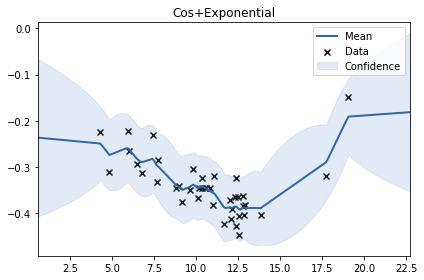

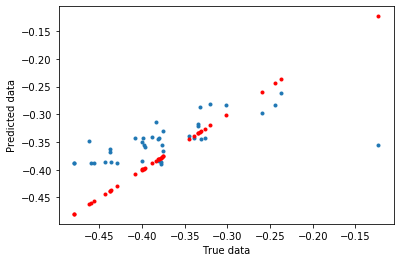

Cross-Predicted Accuracy for Cos+Exponential : 0.264776710545648
Mean absolute error for Cos+Exponential : 0.046272809052624875
Mean squared error for Cos+Exponential : 0.003777954606016616


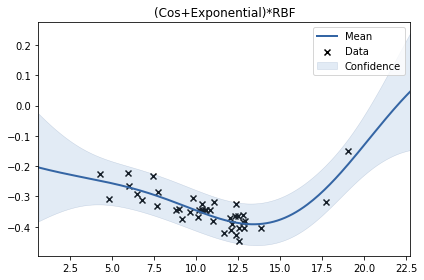

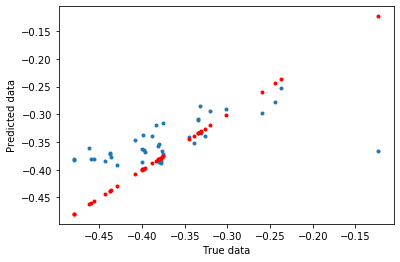

Cross-Predicted Accuracy for (Cos+Exponential)*RBF : 0.25830355645533076
Mean absolute error for (Cos+Exponential)*RBF : 0.044545058389453614
Mean squared error for (Cos+Exponential)*RBF : 0.0038112169940036976


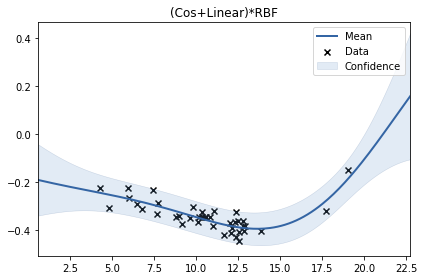

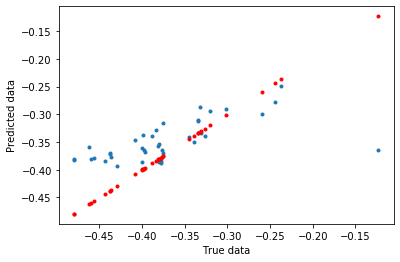

Cross-Predicted Accuracy for (Cos+Linear)*RBF : 0.2623905163141249
Mean absolute error for (Cos+Linear)*RBF : 0.04435340805412819
Mean squared error for (Cos+Linear)*RBF : 0.0037902160966646107


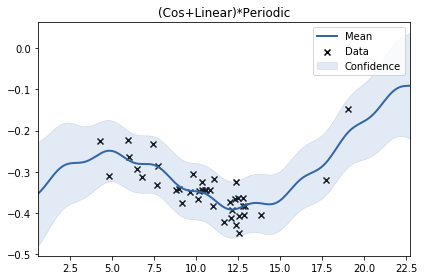

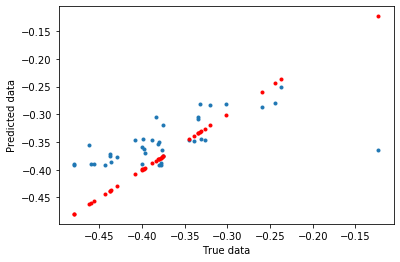

Cross-Predicted Accuracy for (Cos+Linear)*Periodic : 0.27862261105583874
Mean absolute error for (Cos+Linear)*Periodic : 0.044829813368190585
Mean squared error for (Cos+Linear)*Periodic : 0.0037068072629478943


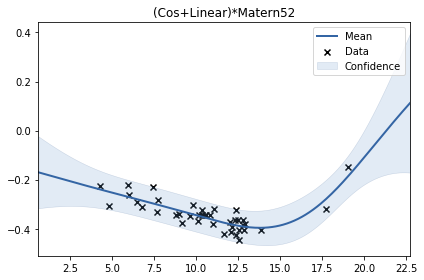

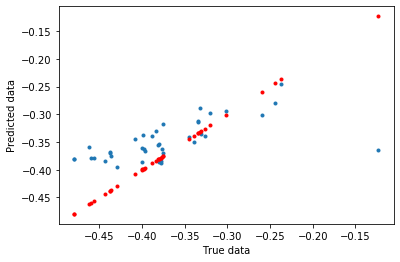

Cross-Predicted Accuracy for (Cos+Linear)*Matern52 : 0.26018077871953316
Mean absolute error for (Cos+Linear)*Matern52 : 0.04436503842292437
Mean squared error for (Cos+Linear)*Matern52 : 0.0038015708625477374
(Cos+Linear)*RBF


In [36]:
from metab_utils import try_gp_regressions
mmal, kmal, resultsmal = try_gp_regressions(mal_1_rt_mod, zik_1_rt_mod-mal_1_rt_mod)

In the end, we are using the RBF kernel for the GP regression.

rbf.,value,constraints,priors
variance,0.07137455873390168,+ve,
lengthscale,7.61386311937561,+ve,


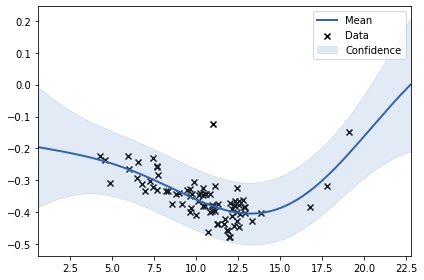

In [37]:
kmal = GPy.kern.RBF(input_dim=1, variance=0.1, lengthscale=6.5)
mmal = GPy.models.GPRegression(mal_1_rt_mod[:,None], zik_1_rt_mod[:,None] - mal_1_rt_mod[:,None],kmal)
mmal.optimize()
mmal.plot()
mmal.parameters[0]

(-1, 1)

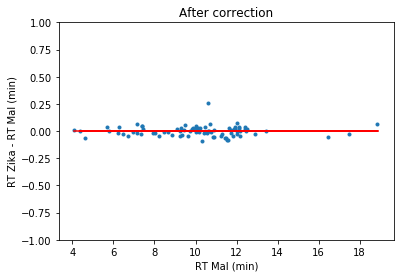

In [38]:
gpr_predicted_data,_ = mmal.predict(np.array(mal_1_rt_mod)[:,None])

plt.plot(np.array(mal_1_rt_mod)[:,None]+gpr_predicted_data, np.array(zik_1_rt_mod)[:,None] - (np.array(mal_1_rt_mod)[:,None]+gpr_predicted_data), '.')
plt.plot(np.array(zik_1_rt_mod)[:,None], np.array(zik_1_rt_mod)[:,None] -np.array(zik_1_rt_mod)[:,None], 'r')
plt.plot()
plt.xlabel('RT Mal (min)')
plt.ylabel('RT Zika - RT Mal (min)')
plt.title('After correction')
plt.ylim(-1,1)

Dumping the model with pickle for future use of the data.

In [40]:
with open('/Users/anamaria/Documents/pymz/mzmine/malmodel.txt', 'wb') as handle:
    pickle.dump(mmal, handle)

The same workflow will be applied for the analysis of the VL vs Zika RT datsets.

#### Zika RT vs VL RT 

In [6]:
from metab_utils import get_rts_between_datasets
hat_1_rt, zik_1_rt, hat1_zik1_diff = get_rts_between_datasets('hat', 'zik', matches)

In [21]:
def plot_and_get_values_for_regression(reference_dataset,refname, compared_dataset,compname, diff, zscore =1.5):
    from metab_utils import return_data_with_no_outliers
    plt.plot(np.array(compared_dataset), np.array(reference_dataset) - np.array(compared_dataset), '.')
    plt.xlabel('RT '+refname+' (min)')
    plt.ylabel('RT '+compname+' - RT '+refname+' (min)')
    
    plt.show()

    compared_dataset_mod, reference_dataset_mod = return_data_with_no_outliers(compared_dataset, reference_dataset, diff, zscore)

    plt.plot(compared_dataset_mod, reference_dataset_mod - compared_dataset_mod, '.')
    plt.plot(reference_dataset_mod[:,None], reference_dataset_mod[:,None] - reference_dataset_mod[:,None], 'r')
    plt.xlabel('RT '+refname+' (min)')
    plt.ylabel('RT '+compname+' - RT '+refname+' (min)')
    plt.title('Before correction')
    plt.ylim(-4,4)
    return reference_dataset_mod, compared_dataset_mod

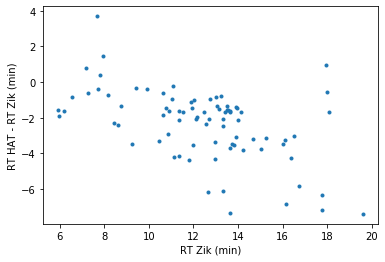

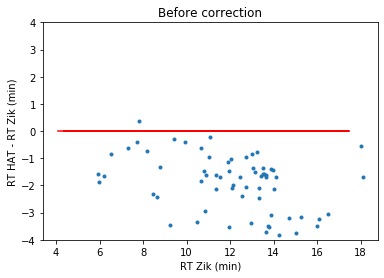

In [67]:
zik_1_rt_mod, hat_1_rt_mod = plot_and_get_values_for_regression(zik_1_rt,'Zik',hat_1_rt,'HAT',  hat1_zik1_diff)

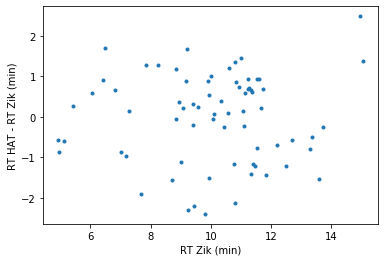

ValueError: x and y can be no greater than 2-D, but have shapes (62, 1, 1) and (62, 1, 1)

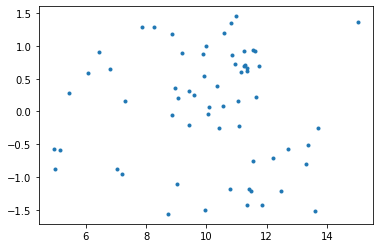

In [68]:
x, y = plot_and_get_values_for_regression(np.array(zik_1_rt_mod)[:,None],'Zik', np.array(hat_mod),'HAT', np.array(zik_1_rt_mod)[:,None] - hat_mod )

In [70]:
x, y = return_data_with_no_outliers(hat_mod, np.array(zik_1_rt_mod), np.array(zik_1_rt_mod)[:,None] - hat_mod, 1.5)

In [73]:
from metab_utils import try_gp_regressions
mhat, khat, results = try_gp_regressions(x, y - x )

AssertionError: 

 /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


mlp.,value,constraints,priors
variance,7830.524167782021,+ve,
weight_variance,5.758897629494177e-06,+ve,
bias_variance,5.562684646268137e-309,+ve,


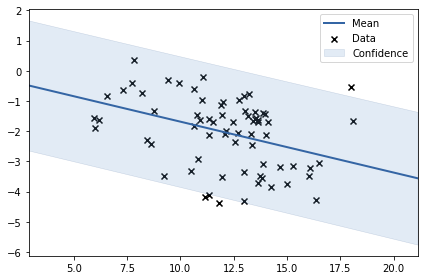

In [61]:
khat = khat
mhat = GPy.models.GPRegression(hat_1_rt_mod[:,None], zik_1_rt_mod[:,None]-hat_1_rt_mod[:,None], khat)

mhat.optimize()
mhat.plot()
mhat.parameters[0]

(-4, 4)

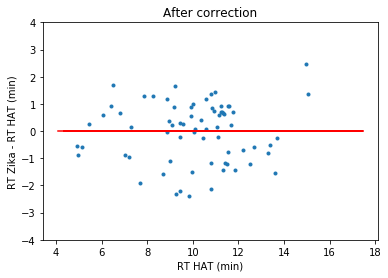

In [62]:
gpr_predicted_data,_ = mhat.predict(np.array(hat_1_rt_mod)[:,None])

plt.plot(np.array(hat_1_rt_mod)[:,None]+gpr_predicted_data, np.array(zik_1_rt_mod)[:,None] - (np.array(hat_1_rt_mod)[:,None]+gpr_predicted_data), '.')
plt.plot(np.array(zik_1_rt_mod)[:,None], np.array(zik_1_rt_mod)[:,None] -np.array(zik_1_rt_mod)[:,None], 'r')
plt.plot()
plt.xlabel('RT HAT (min)')
plt.ylabel('RT Zika - RT HAT (min)')
plt.title('After correction')
plt.ylim(-4,4)

In [47]:
with open('/Users/anamaria/Documents/pymz/mzmine/vlmodel.txt', 'wb') as handle:
    pickle.dump(mvl, handle)

In [31]:
hat_mod = np.array(hat_1_rt_mod)[:,None]+gpr_predicted_data

In [45]:
len(hat_mod)

70

In [44]:
len(np.subtract(zik_1_rt_mod,hat_mod))

70

In [50]:
len(zik_1_rt_mod)

70

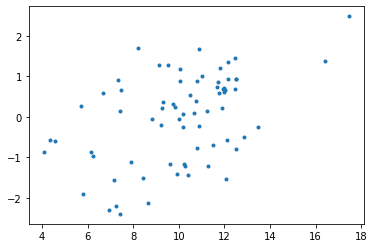

In [54]:
plt.plot(zik_1_rt_mod, np.array(zik_1_rt_mod)[:,None] - hat_mod, '.')